# NYC OpenData - Department of Homelessness Analysis

#### Sources

- Evictions <br>
https://dev.socrata.com/foundry/data.cityofnewyork.us/6z8x-wfk4

- DHS Daily Report <br>
https://dev.socrata.com/foundry/data.cityofnewyork.us/k46n-sa2m

- DYCD Demographics by Zip Code <br>
https://dev.socrata.com/foundry/data.cityofnewyork.us/hebw-6hze



#### References


- Time Series <br>
https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html

## Imports


In [78]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [130]:
import pandas as pd
from sodapy import Socrata
import plotly.express as px
import nbformat
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import datetime
import statsmodels.api as sm
import seaborn as sns
import plotly.io as pio

## Read data from API to Dataframes

**Evictions**

In [80]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/6z8x-wfk4
client = Socrata("data.cityofnewyork.us", None)
results = client.get("6z8x-wfk4",limit=80000)

# Convert to pandas DataFrame
evictions_df = pd.DataFrame.from_records(results)

**Dept of Homelessness Daily Report**

In [81]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/k46n-sa2m
client = Socrata("data.cityofnewyork.us", None)
results = client.get("k46n-sa2m",limit=80000)

# Convert to pandas DataFrame
dhs_daily_df = pd.DataFrame.from_records(results)

**DYCD - Dept of Youth & Community Development** - 
Demographics by Zip Code

In [82]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/hebw-6hze

client = Socrata("data.cityofnewyork.us", None)
results = client.get("hebw-6hze",limit=80000)


# Convert to pandas DataFrame
demos_by_zip_df = pd.DataFrame.from_records(results)

## Exploratory Data Analysis

### Schema Info

In [83]:
evictions_df['executed_date'] = pd.to_datetime(evictions_df['executed_date'])
evictions_df.sort_values(by='executed_date',ascending=False)

,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip,ejectment,eviction_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
54074,317973/22,16662,90-11 160TH STREET APT B506,B506,2023-07-06,Robert,Renzulli,Residential,QUEENS,11432,Not an Ejectment,Possession,40.704969,-73.799903,12,24,44601,4000000,4097577501,Jamaica
16797,305757/21,117070,10 RICHMAN PLAZA,37H,2023-07-06,Justin,Grossman,Residential,BRONX,10453,Not an Ejectment,Possession,40.851533,-73.922961,5,16,53,2093973,2028820229,University Heights-Morris Heights
29840,300506/23,16286,259 MONTAUK AVENUE,2ND FL APT,2023-07-06,Robert,Renzulli,Residential,BROOKLYN,11208,Not an Ejectment,Possession,40.672539,-73.877532,5,42,1194,3393986,3040400104,East New York
63148,300902/22,120059,196 SPRING STREET,4,2023-07-06,Justin,Grossman,Residential,MANHATTAN,10012,Not an Ejectment,Possession,40.725130,-74.003153,2,3,47,1007354,1004890018,SoHo-TriBeCa-Civic Center-Little Italy
58447,318157/22N,115285,75 SHERMAN AVENUE A/ K/A 73-75 SHERMAN AVENUE,32,2023-07-06,Justin,Grossman,Residential,MANHATTAN,10040,Not an Ejectment,Possession,40.863397,-73.926465,12,10,285,1064160,1021740034,Washington Heights North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,31314/16,053818,65 EAST 190TH STREET,2J,2017-01-03,Justin,Grossman,Residential,BRONX,10468,Not an Ejectment,Possession,40.862984,-73.898367,7,14,401,2013930,2031750007,Bedford Park-Fordham North
66577,N070028/16,371877,315 EAST 102ND ST,729,2017-01-03,Richard,McCoy,Residential,MANHATTAN,10029,Not an Ejectment,Possession,40.787834,-73.943766,11,8,164,1088305,1016740010,East Harlem South
69040,55509/16,462258,1880 LAFAYETTE AVENU E,22D,2017-01-03,Danny,Weinheim,Residential,BRONX,10473,Not an Ejectment,Possession,40.821892,-73.859109,9,18,16,2092711,2036000004,Soundview-Castle Hill-Clason Point-Harding Park
34942,74907/16,7346,108-02 LIBERTY AVENUE,NaN,2017-01-03,Edward,Guida,Commercial,QUEENS,11419,Not an Ejectment,Possession,40.683729,-73.833682,10,28,96,4202271,4095310001,South Ozone Park


In [84]:
dhs_daily_df['date_of_census'] = pd.to_datetime(dhs_daily_df['date_of_census'])
dhs_daily_df

,date_of_census,total_adults_in_shelter,total_children_in_shelter,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,adult_families_in_shelter,individuals_in_adult_families_in_shelter
0,2023-07-08,53471,27865,81336,16943,4729,21672,16329,25665,27865,53530,2887,6134
1,2023-07-07,53545,27859,81404,16968,4719,21687,16308,25654,27859,53513,2922,6204
2,2023-07-06,53579,27818,81397,17025,4729,21754,16287,25628,27818,53446,2918,6197
3,2023-07-05,53763,27811,81574,17148,4721,21869,16306,25663,27811,53474,2935,6231
4,2023-07-04,53463,27684,81147,16965,4699,21664,16246,25552,27684,53236,2946,6247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,2013-08-25,28458,21400,49858,7230,2704,9934,10324,14694,21400,36094,1804,3830
3543,2013-08-24,28274,21343,49617,7110,2690,9800,10291,14650,21343,35993,1801,3824
3544,2013-08-23,28257,21291,49548,7149,2671,9820,10266,14611,21291,35902,1802,3826
3545,2013-08-22,28366,21324,49690,7201,2716,9917,10274,14622,21324,35946,1803,3827


In [85]:
dhs_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 13 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   date_of_census                                           3547 non-null   datetime64[ns]
 1   total_adults_in_shelter                                  3547 non-null   object        
 2   total_children_in_shelter                                3547 non-null   object        
 3   total_individuals_in_shelter                             3547 non-null   object        
 4   single_adult_men_in_shelter                              3547 non-null   object        
 5   single_adult_women_in_shelter                            3547 non-null   object        
 6   total_single_adults_in_shelter                           3547 non-null   object        
 7   families_with_children_in_shelter                  

In [86]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77747 entries, 0 to 77746
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   court_index_number          77747 non-null  object        
 1   docket_number               77747 non-null  object        
 2   eviction_address            77747 non-null  object        
 3   eviction_apt_num            65063 non-null  object        
 4   executed_date               77747 non-null  datetime64[ns]
 5   marshal_first_name          77747 non-null  object        
 6   marshal_last_name           77747 non-null  object        
 7   residential_commercial_ind  77747 non-null  object        
 8   borough                     77747 non-null  object        
 9   eviction_zip                77747 non-null  object        
 10  ejectment                   77747 non-null  object        
 11  eviction_possession         77747 non-null  object    

In [87]:
demos_by_zip_df['data_os_of_date'] = pd.to_datetime(demos_by_zip_df['data_os_of_date'])
demos_by_zip_df

,data_os_of_date,zip_code,program_type,female_count,female_percentage,male_count,male_percentage,gender_nonconforming_count,gender_nonconforming,american_indian_or_alaskan,...,non_binary_not_female_or_male_count,non_binary_not_female_or_male_percentage,not_sure_gender_identity_count,not_sure_gender_identity_percentage,two_spirit_native_american_first_nations_count,two_spirit_native_american_first_nations_percentage,middle_eastern_and_north_african_count,middle_eastern_and_north_african_percentage,other_count,other_percentage
0,2020-07-16,0,Beacon,3,0.1,4,0.13,0,0,0,...,0,0,0,0,0,0,0,0,5,0.16
1,2020-07-16,1017,Cornerstone,1,0.03,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.03
2,2020-07-16,2121,Beacon,0,0,1,0.03,0,0,0,...,0,0,0,0,0,0,0,0,1,0.03
3,2020-07-16,2420,Beacon,1,0.03,0,0,0,0,0,...,0,0,0,0,0,0,1,0.03,0,0
4,2020-07-16,2453,Beacon,0,0,1,0.03,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908,2019-06-01,91103,Beacon,1,0.03,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4909,2019-06-01,92620,Beacon,2,0.06,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4910,2019-06-01,94539,Cornerstone,0,0,5,0.15,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4911,2019-06-01,95351,Beacon,0,0,1,0.03,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77747 entries, 0 to 77746
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   court_index_number          77747 non-null  object        
 1   docket_number               77747 non-null  object        
 2   eviction_address            77747 non-null  object        
 3   eviction_apt_num            65063 non-null  object        
 4   executed_date               77747 non-null  datetime64[ns]
 5   marshal_first_name          77747 non-null  object        
 6   marshal_last_name           77747 non-null  object        
 7   residential_commercial_ind  77747 non-null  object        
 8   borough                     77747 non-null  object        
 9   eviction_zip                77747 non-null  object        
 10  ejectment                   77747 non-null  object        
 11  eviction_possession         77747 non-null  object    

In [89]:
dhs_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 13 columns):
 #   Column                                                   Non-Null Count  Dtype         
---  ------                                                   --------------  -----         
 0   date_of_census                                           3547 non-null   datetime64[ns]
 1   total_adults_in_shelter                                  3547 non-null   object        
 2   total_children_in_shelter                                3547 non-null   object        
 3   total_individuals_in_shelter                             3547 non-null   object        
 4   single_adult_men_in_shelter                              3547 non-null   object        
 5   single_adult_women_in_shelter                            3547 non-null   object        
 6   total_single_adults_in_shelter                           3547 non-null   object        
 7   families_with_children_in_shelter                  

In [90]:
demos_by_zip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 51 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   data_os_of_date                                      4913 non-null   datetime64[ns]
 1   zip_code                                             4913 non-null   object        
 2   program_type                                         4913 non-null   object        
 3   female_count                                         4913 non-null   object        
 4   female_percentage                                    4913 non-null   object        
 5   male_count                                           4913 non-null   object        
 6   male_percentage                                      4913 non-null   object        
 7   gender_nonconforming_count                           4913 non-null   object        
 8 

### Handling Nulls

In [91]:
# check for nulls 
evictions_df.isna().any()

court_index_number            False
docket_number                 False
eviction_address              False
eviction_apt_num               True
executed_date                 False
marshal_first_name            False
marshal_last_name             False
residential_commercial_ind    False
borough                       False
eviction_zip                  False
ejectment                     False
eviction_possession           False
latitude                       True
longitude                      True
community_board                True
council_district               True
census_tract                   True
bin                            True
bbl                            True
nta                            True
dtype: bool

In [92]:
# check for nulls 
dhs_daily_df.isna().any()

date_of_census                                             False
total_adults_in_shelter                                    False
total_children_in_shelter                                  False
total_individuals_in_shelter                               False
single_adult_men_in_shelter                                False
single_adult_women_in_shelter                              False
total_single_adults_in_shelter                             False
families_with_children_in_shelter                          False
adults_in_families_with_children_in_shelter                False
children_in_families_with_children_in_shelter              False
total_individuals_in_families_with_children_in_shelter_    False
adult_families_in_shelter                                  False
individuals_in_adult_families_in_shelter                   False
dtype: bool

In [93]:
demos_by_zip_df.isna().any()

data_os_of_date                                        False
zip_code                                               False
program_type                                           False
female_count                                           False
female_percentage                                      False
male_count                                             False
male_percentage                                        False
gender_nonconforming_count                             False
gender_nonconforming                                   False
american_indian_or_alaskan                             False
american_indian_or_alaskan_1                           False
asian_count                                            False
asian_percentage                                       False
black_or_african_american                              False
black_or_african_american_1                            False
multi_race_count                                       False
multi_race_percentage   

### Finding Duplicates

In [94]:
# function to find duplicates within columns in a dataframe

def find_duplicates(df):
    duplicates = pd.DataFrame(columns=['Column', 'Field', 'Count'])
    for column in df.columns:
        column_duplicates = df[df.duplicated(subset=column, keep=False)][column]
        column_duplicates_count = column_duplicates.value_counts()
        if not column_duplicates_count.empty:
            column_duplicates_df = pd.DataFrame({'Column': column, 'Field': column_duplicates_count.index, 'Count': column_duplicates_count.values})
            duplicates = pd.concat([duplicates, column_duplicates_df], ignore_index=True)
    return duplicates


In [95]:
#duplicates_df = find_duplicates(results_df)
#duplicates_df

In [96]:
#filtered_duplicates = duplicates_df[duplicates_df['Column'] == 'executed_date']
#print(filtered_duplicates)

### Data Pivots

#### Evictions

In [97]:
counts_by_boro_piv = pd.pivot_table(evictions_df,values='docket_number', aggfunc='count',index='executed_date',columns='borough').reset_index().sort_values(by='executed_date',ascending=False)
#counts_by_boro_piv = pd.pivot_table(results_df,values='docket_number', aggfunc='count',index='executed_date',columns='borough')

In [98]:
# Convert 'executed_date' column to datetime
counts_by_boro_piv['executed_date'] = pd.to_datetime(counts_by_boro_piv['executed_date'])

In [99]:
counts_by_boro_piv

borough,executed_date,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
1263,2023-07-06,17.0,13.0,9.0,2.0,NaN
1262,2023-07-05,1.0,21.0,7.0,11.0,2.0
1261,2023-07-03,6.0,6.0,11.0,7.0,NaN
1260,2023-06-30,22.0,20.0,1.0,6.0,1.0
1259,2023-06-29,34.0,8.0,17.0,1.0,NaN
...,...,...,...,...,...,...
4,2017-01-09,24.0,49.0,18.0,12.0,2.0
3,2017-01-06,50.0,59.0,14.0,26.0,1.0
2,2017-01-05,52.0,18.0,25.0,27.0,5.0
1,2017-01-04,44.0,64.0,11.0,19.0,6.0


#### DHS Time Series Analysis

Questions to Answer <br>
- How has the homeless population in NYC evolved over time?

In [100]:
dhs_daily_df

,date_of_census,total_adults_in_shelter,total_children_in_shelter,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,adult_families_in_shelter,individuals_in_adult_families_in_shelter
0,2023-07-08,53471,27865,81336,16943,4729,21672,16329,25665,27865,53530,2887,6134
1,2023-07-07,53545,27859,81404,16968,4719,21687,16308,25654,27859,53513,2922,6204
2,2023-07-06,53579,27818,81397,17025,4729,21754,16287,25628,27818,53446,2918,6197
3,2023-07-05,53763,27811,81574,17148,4721,21869,16306,25663,27811,53474,2935,6231
4,2023-07-04,53463,27684,81147,16965,4699,21664,16246,25552,27684,53236,2946,6247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,2013-08-25,28458,21400,49858,7230,2704,9934,10324,14694,21400,36094,1804,3830
3543,2013-08-24,28274,21343,49617,7110,2690,9800,10291,14650,21343,35993,1801,3824
3544,2013-08-23,28257,21291,49548,7149,2671,9820,10266,14611,21291,35902,1802,3826
3545,2013-08-22,28366,21324,49690,7201,2716,9917,10274,14622,21324,35946,1803,3827


In [101]:
# get percentage of total per subgroup
# denominator is always total_individuals_in_shelter
# create a for loop for every column except total_individuals_in_shelter, divide & then append result as column name + concat perc_ as prefix

# Create a list to store the new column names
new_columns = []

# Iterate over each column
for column in dhs_daily_df.columns:
    if column != 'total_individuals_in_shelter' and column != 'date_of_census':
        # Generate the new column name with the prefix "perc_" followed by the original column name
        new_column = 'perc_' + column
        
        # Divide the values in the current column by the values in the 'total_individuals_in_shelter' column
        new_values = ((dhs_daily_df[column].astype(float) / dhs_daily_df['total_individuals_in_shelter'].astype(float))*100).round(2)
        
        # Append the new column to the DataFrame
        dhs_daily_df[new_column] = new_values
        
        # Append the new column name to the list
        new_columns.append(new_column)

dhs_daily_df

,date_of_census,total_adults_in_shelter,total_children_in_shelter,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,...,perc_total_children_in_shelter,perc_single_adult_men_in_shelter,perc_single_adult_women_in_shelter,perc_total_single_adults_in_shelter,perc_families_with_children_in_shelter,perc_adults_in_families_with_children_in_shelter,perc_children_in_families_with_children_in_shelter,perc_total_individuals_in_families_with_children_in_shelter_,perc_adult_families_in_shelter,perc_individuals_in_adult_families_in_shelter
0,2023-07-08,53471,27865,81336,16943,4729,21672,16329,25665,27865,...,34.26,20.83,5.81,26.65,20.08,31.55,34.26,65.81,3.55,7.54
1,2023-07-07,53545,27859,81404,16968,4719,21687,16308,25654,27859,...,34.22,20.84,5.80,26.64,20.03,31.51,34.22,65.74,3.59,7.62
2,2023-07-06,53579,27818,81397,17025,4729,21754,16287,25628,27818,...,34.18,20.92,5.81,26.73,20.01,31.49,34.18,65.66,3.58,7.61
3,2023-07-05,53763,27811,81574,17148,4721,21869,16306,25663,27811,...,34.09,21.02,5.79,26.81,19.99,31.46,34.09,65.55,3.60,7.64
4,2023-07-04,53463,27684,81147,16965,4699,21664,16246,25552,27684,...,34.12,20.91,5.79,26.70,20.02,31.49,34.12,65.60,3.63,7.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,2013-08-25,28458,21400,49858,7230,2704,9934,10324,14694,21400,...,42.92,14.50,5.42,19.92,20.71,29.47,42.92,72.39,3.62,7.68
3543,2013-08-24,28274,21343,49617,7110,2690,9800,10291,14650,21343,...,43.02,14.33,5.42,19.75,20.74,29.53,43.02,72.54,3.63,7.71
3544,2013-08-23,28257,21291,49548,7149,2671,9820,10266,14611,21291,...,42.97,14.43,5.39,19.82,20.72,29.49,42.97,72.46,3.64,7.72
3545,2013-08-22,28366,21324,49690,7201,2716,9917,10274,14622,21324,...,42.91,14.49,5.47,19.96,20.68,29.43,42.91,72.34,3.63,7.70


In [102]:
filtered_columns = []
for column in dhs_daily_df.columns:
    if column.startswith('perc_'):
        filtered_columns.append(column)  
dhs_daily_df[filtered_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   perc_total_adults_in_shelter                                  3547 non-null   float64
 1   perc_total_children_in_shelter                                3547 non-null   float64
 2   perc_single_adult_men_in_shelter                              3547 non-null   float64
 3   perc_single_adult_women_in_shelter                            3547 non-null   float64
 4   perc_total_single_adults_in_shelter                           3547 non-null   float64
 5   perc_families_with_children_in_shelter                        3547 non-null   float64
 6   perc_adults_in_families_with_children_in_shelter              3547 non-null   float64
 7   perc_children_in_families_with_children_in_shelter            3547 no

In [103]:
# convert to monthly & quarterly
# Set the 'date' column as the index
dhs_daily_df.set_index('date_of_census', inplace=True)

# Resample to monthly average data
monthly_avg_df = dhs_daily_df.resample('M').mean()

# Resample to quarterly average data
quarterly_avg_df = dhs_daily_df.resample('Q').mean()

# Resample to quarterly average data
yearly_avg_df = dhs_daily_df.resample('Y').mean()

In [104]:
monthly_avg_df = monthly_avg_df.filter(regex='^perc_')
monthly_avg_df

,perc_total_adults_in_shelter,perc_total_children_in_shelter,perc_single_adult_men_in_shelter,perc_single_adult_women_in_shelter,perc_total_single_adults_in_shelter,perc_families_with_children_in_shelter,perc_adults_in_families_with_children_in_shelter,perc_children_in_families_with_children_in_shelter,perc_total_individuals_in_families_with_children_in_shelter_,perc_adult_families_in_shelter,perc_individuals_in_adult_families_in_shelter
date_of_census,,,,,,,,,,,
2013-08-31,57.039091,42.960909,14.407273,5.425455,19.832727,20.706364,29.490000,42.960909,72.449091,3.636364,7.717273
2013-09-30,56.959643,43.040357,14.280000,5.458571,19.738214,20.718571,29.518929,43.040357,72.559286,3.629286,7.702500
2013-10-31,56.890000,43.110000,14.184333,5.402000,19.585667,20.738333,29.562667,43.110000,72.673667,3.649333,7.741000
2013-11-30,56.753333,43.246667,14.172593,5.292593,19.464815,20.717407,29.510000,43.246667,72.757407,3.668519,7.778148
2013-12-31,56.800000,43.200000,14.334667,5.273000,19.607000,20.673333,29.412000,43.200000,72.612667,3.669000,7.781000
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,67.626875,32.373125,23.732813,6.320000,30.053438,19.033438,29.306563,32.373125,61.680312,3.894062,8.266562
2023-04-30,67.515000,32.485000,23.559000,6.147333,29.706667,19.094667,29.602667,32.485000,62.088333,3.869333,8.206000
2023-05-31,67.046129,32.953871,22.748065,5.811935,28.558710,19.371290,30.430968,32.953871,63.386129,3.805161,8.057097


In [105]:
quarterly_avg_df = quarterly_avg_df.filter(regex='^perc_')
quarterly_avg_df

,perc_total_adults_in_shelter,perc_total_children_in_shelter,perc_single_adult_men_in_shelter,perc_single_adult_women_in_shelter,perc_total_single_adults_in_shelter,perc_families_with_children_in_shelter,perc_adults_in_families_with_children_in_shelter,perc_children_in_families_with_children_in_shelter,perc_total_individuals_in_families_with_children_in_shelter_,perc_adult_families_in_shelter,perc_individuals_in_adult_families_in_shelter
date_of_census,,,,,,,,,,,
2013-09-30,56.982051,43.017949,14.315897,5.449231,19.764872,20.715128,29.510769,43.017949,72.528205,3.631282,7.706667
2013-12-31,56.816552,43.183448,14.232529,5.323563,19.555517,20.709425,29.494368,43.183448,72.678621,3.662069,7.766322
2014-03-31,56.837079,43.162921,14.454494,5.289888,19.744157,20.624607,29.395281,43.162921,72.558202,3.633371,7.697303
2014-06-30,56.858046,43.141954,14.299080,5.225517,19.523448,20.835517,29.794713,43.141954,72.937701,3.580805,7.538506
2014-09-30,56.842111,43.157889,13.908000,5.353444,19.261333,20.857778,29.911444,43.157778,73.069556,3.647000,7.669333
2014-12-31,56.834167,43.165833,13.821071,5.387143,19.208690,20.886667,29.925000,43.165833,73.091310,3.654762,7.700357
2015-03-31,57.724471,42.275529,14.667294,5.477059,20.144706,20.624706,29.740353,42.275529,72.015765,3.723529,7.839647
2015-06-30,58.582442,41.417558,15.235349,5.728837,20.964419,20.680814,29.665116,41.417558,71.082093,3.785698,7.953023
2015-09-30,58.953956,41.046044,15.358132,6.060220,21.418681,20.823956,29.632747,41.046044,70.679231,3.768242,7.901868


In [106]:
yearly_avg_df = yearly_avg_df.filter(regex='^perc_')
yearly_avg_df

,perc_total_adults_in_shelter,perc_total_children_in_shelter,perc_single_adult_men_in_shelter,perc_single_adult_women_in_shelter,perc_total_single_adults_in_shelter,perc_families_with_children_in_shelter,perc_adults_in_families_with_children_in_shelter,perc_children_in_families_with_children_in_shelter,perc_total_individuals_in_families_with_children_in_shelter_,perc_adult_families_in_shelter,perc_individuals_in_adult_families_in_shelter
date_of_census,,,,,,,,,,,
2013-12-31,56.867778,43.132222,14.258333,5.362460,19.620317,20.711190,29.499444,43.132222,72.632063,3.652540,7.747857
2014-12-31,56.842886,43.157114,14.123314,5.313571,19.436629,20.799886,29.754429,43.157086,72.911971,3.628943,7.651371
2015-12-31,58.678980,41.321020,15.259490,5.874901,21.134901,20.769377,29.641501,41.321020,70.962380,3.763824,7.902408
2016-12-31,60.522707,39.477320,16.008619,6.363149,22.371851,21.448978,29.772983,39.477320,69.250801,3.992624,8.377514
2017-12-31,61.778688,38.221312,17.125977,6.562128,23.688426,21.332653,29.225598,38.221312,67.446706,4.206560,8.864781
2018-12-31,62.853636,37.146364,18.683444,7.092617,25.776198,20.945950,28.362204,37.146364,65.508733,4.117603,8.715152
2019-12-31,63.868297,36.131703,20.112830,7.496923,27.610000,20.446401,27.339918,36.131703,63.471731,4.224945,8.918599
2020-12-31,65.660716,34.339284,23.305950,8.146942,31.452865,19.317741,25.720303,34.339284,60.059917,4.021267,8.487410
2021-12-31,67.823929,32.176071,27.124038,8.885495,36.009533,18.482555,24.308022,32.176071,56.484258,3.569203,7.506346


In [107]:
quarterly_avg_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2013-09-30 to 2023-09-30
Freq: Q-DEC
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   perc_total_adults_in_shelter                                  41 non-null     float64
 1   perc_total_children_in_shelter                                41 non-null     float64
 2   perc_single_adult_men_in_shelter                              41 non-null     float64
 3   perc_single_adult_women_in_shelter                            41 non-null     float64
 4   perc_total_single_adults_in_shelter                           41 non-null     float64
 5   perc_families_with_children_in_shelter                        41 non-null     float64
 6   perc_adults_in_families_with_children_in_shelter              41 non-null     float64
 7   perc_children_in_families_with_children_i

### Data Visualizations

#### evictions

In [108]:
# Melt the DataFrame
counts_by_boro_fig = counts_by_boro_piv.melt(id_vars='executed_date', var_name='borough', value_name='count')

In [109]:
# Create bar plot using Plotly
fig = px.bar(counts_by_boro_fig, x='executed_date', y='count', color='borough', barmode='group')

# Display the plot
fig.show()

#### dept homelessness

##### time series

In [110]:
dhs_daily_df.info()
#monthly_avg_df.info()
#quarterly_avg_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3547 entries, 2023-07-08 to 2013-08-21
Data columns (total 23 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   total_adults_in_shelter                                       3547 non-null   object 
 1   total_children_in_shelter                                     3547 non-null   object 
 2   total_individuals_in_shelter                                  3547 non-null   object 
 3   single_adult_men_in_shelter                                   3547 non-null   object 
 4   single_adult_women_in_shelter                                 3547 non-null   object 
 5   total_single_adults_in_shelter                                3547 non-null   object 
 6   families_with_children_in_shelter                             3547 non-null   object 
 7   adults_in_families_with_children_in_shelter        

In [111]:
# filter functions

# date filter
def get_date(date_of_census, start_date, end_date):
    date_of_census=date_of_census
    start_date=start_date
    end_date=end_date
    return start_date <= date_of_census <= end_date

# column filter
def get_columns(df, desired_columns):
    columns = []
    for i, column in enumerate(df.columns):
        if i in desired_columns:
            columns.append(column)
    return df[columns]

In [112]:
start_date = datetime.datetime(2013, 1, 1)
end_date = datetime.datetime(2023, 6, 30)

# Convert index values to datetime
dhs_daily_df.index = pd.to_datetime(dhs_daily_df.index)

# Apply date filter
filtered_data = dhs_daily_df[dhs_daily_df.index.to_series().apply(get_date, start_date=start_date, end_date=end_date)]
filtered_data

,total_adults_in_shelter,total_children_in_shelter,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,...,perc_total_children_in_shelter,perc_single_adult_men_in_shelter,perc_single_adult_women_in_shelter,perc_total_single_adults_in_shelter,perc_families_with_children_in_shelter,perc_adults_in_families_with_children_in_shelter,perc_children_in_families_with_children_in_shelter,perc_total_individuals_in_families_with_children_in_shelter_,perc_adult_families_in_shelter,perc_individuals_in_adult_families_in_shelter
date_of_census,,,,,,,,,,,,,,,,,,,,,
2023-06-30,53412,27654,81066,16927,4687,21614,16232,25539,27654,53193,...,34.11,20.88,5.78,26.66,20.02,31.50,34.11,65.62,3.64,7.72
2023-06-29,53545,27635,81180,17047,4700,21747,16228,25534,27635,53169,...,34.04,21.00,5.79,26.79,19.99,31.45,34.04,65.50,3.64,7.72
2023-06-28,53521,27560,81081,17107,4691,21798,16181,25469,27560,53029,...,33.99,21.10,5.79,26.88,19.96,31.41,33.99,65.40,3.64,7.71
2023-06-27,53615,27575,81190,17159,4698,21857,16194,25477,27575,53052,...,33.96,21.13,5.79,26.92,19.95,31.38,33.96,65.34,3.65,7.74
2023-06-26,53501,27430,80931,17133,4691,21824,16129,25377,27430,52807,...,33.89,21.17,5.80,26.97,19.93,31.36,33.89,65.25,3.67,7.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-25,28458,21400,49858,7230,2704,9934,10324,14694,21400,36094,...,42.92,14.50,5.42,19.92,20.71,29.47,42.92,72.39,3.62,7.68
2013-08-24,28274,21343,49617,7110,2690,9800,10291,14650,21343,35993,...,43.02,14.33,5.42,19.75,20.74,29.53,43.02,72.54,3.63,7.71
2013-08-23,28257,21291,49548,7149,2671,9820,10266,14611,21291,35902,...,42.97,14.43,5.39,19.82,20.72,29.49,42.97,72.46,3.64,7.72


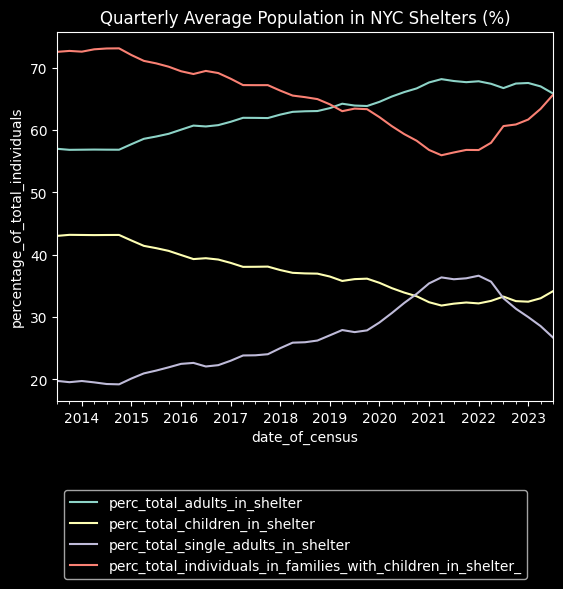

In [113]:
register_matplotlib_converters()
plt.style.use("dark_background")

#filtered population
desired_columns = [0, 1, 4, 8,]
filtered_data = get_columns(quarterly_avg_df,desired_columns)

filtered_data.plot()

# Add a title
plt.title("Quarterly Average Population in NYC Shelters (%)")

# Add a y-axis label
plt.ylabel("percentage_of_total_individuals")

# Move the legend to the upper right corner
plt.legend(loc='lower left',bbox_to_anchor=(0, -0.5))

# Show the plot
plt.show()


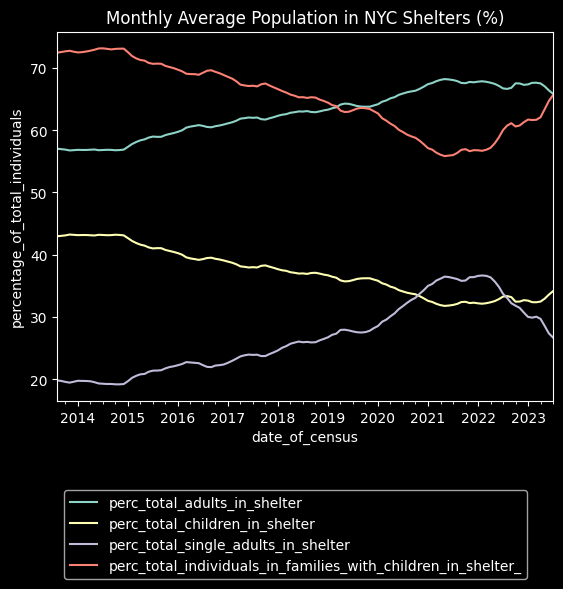

In [114]:
# Monthly view
register_matplotlib_converters()
plt.style.use("dark_background")

# filtered date
#filtered_data = quarterly_avg_df[quarterly_avg_df.index.to_series().apply(get_date)]

#filtered population
desired_columns = [0, 1, 4, 8,]
filtered_data = get_columns(monthly_avg_df,desired_columns)

filtered_data.plot()

# Add a title
plt.title("Monthly Average Population in NYC Shelters (%)")

# Add a y-axis label
plt.ylabel("percentage_of_total_individuals")

# Move the legend to the upper right corner
plt.legend(loc='lower left',bbox_to_anchor=(0, -0.5))
# Show the plot
plt.show()

In [115]:
dhs_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3547 entries, 2023-07-08 to 2013-08-21
Data columns (total 23 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   total_adults_in_shelter                                       3547 non-null   object 
 1   total_children_in_shelter                                     3547 non-null   object 
 2   total_individuals_in_shelter                                  3547 non-null   object 
 3   single_adult_men_in_shelter                                   3547 non-null   object 
 4   single_adult_women_in_shelter                                 3547 non-null   object 
 5   total_single_adults_in_shelter                                3547 non-null   object 
 6   families_with_children_in_shelter                             3547 non-null   object 
 7   adults_in_families_with_children_in_shelter        

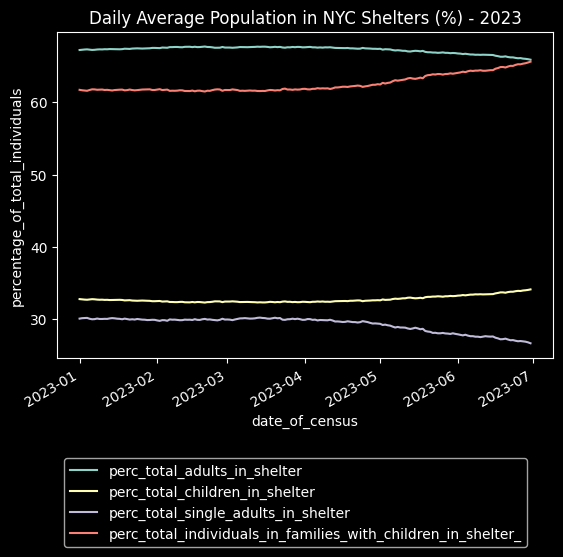

In [116]:
# Daily View 
register_matplotlib_converters()
plt.style.use("dark_background")

# filtered date
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 6, 30)

# Convert index values to datetime
dhs_daily_df.index = pd.to_datetime(dhs_daily_df.index)

# Apply date filter
filtered_data = dhs_daily_df[dhs_daily_df.index.to_series().apply(get_date, start_date=start_date, end_date=end_date)]


#filtered population
desired_columns = [0, 1, 4, 8,]
filtered_data = get_columns(filtered_data.filter(regex='^perc_'),desired_columns)

filtered_data.plot()

# Add a title
plt.title("Daily Average Population in NYC Shelters (%) - 2023")

# Add a y-axis label
plt.ylabel("percentage_of_total_individuals")

# Move the legend to the upper right corner
plt.legend(loc='lower left',bbox_to_anchor=(0, -0.6))
# Show the plot
plt.show()


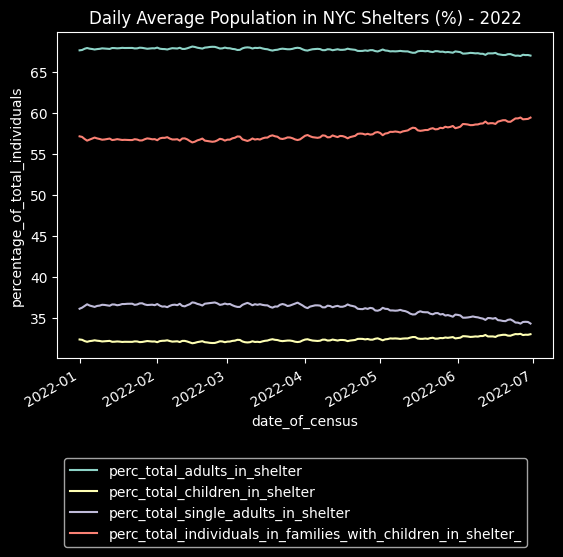

In [117]:
# Daily View
register_matplotlib_converters()
plt.style.use("dark_background")

# filtered date
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2022, 6, 30)

# Convert index values to datetime
dhs_daily_df.index = pd.to_datetime(dhs_daily_df.index)

# Apply date filter
filtered_data = dhs_daily_df[dhs_daily_df.index.to_series().apply(get_date, start_date=start_date, end_date=end_date)]


#filtered population
desired_columns = [0, 1, 4, 8,]
filtered_data = get_columns(filtered_data.filter(regex='^perc_'),desired_columns)

filtered_data.plot()

# Add a title
plt.title("Daily Average Population in NYC Shelters (%) - 2022")

# Add a y-axis label
plt.ylabel("percentage_of_total_individuals")

# Move the legend to the upper right corner
plt.legend(loc='lower left',bbox_to_anchor=(0, -0.6))
# Show the plot
plt.show()


##### correlation analyses

In [118]:
desired_columns = [0, 1, 4, 8,]
filtered_data = get_columns(quarterly_avg_df,desired_columns)
filtered_data
#dhs_daily_df

,perc_total_adults_in_shelter,perc_total_children_in_shelter,perc_total_single_adults_in_shelter,perc_total_individuals_in_families_with_children_in_shelter_
date_of_census,,,,
2013-09-30,56.982051,43.017949,19.764872,72.528205
2013-12-31,56.816552,43.183448,19.555517,72.678621
2014-03-31,56.837079,43.162921,19.744157,72.558202
2014-06-30,56.858046,43.141954,19.523448,72.937701
2014-09-30,56.842111,43.157889,19.261333,73.069556
2014-12-31,56.834167,43.165833,19.208690,73.091310
2015-03-31,57.724471,42.275529,20.144706,72.015765
2015-06-30,58.582442,41.417558,20.964419,71.082093
2015-09-30,58.953956,41.046044,21.418681,70.679231


In [119]:
'''correlation_matrix = filtered_data.corr()  # Correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r')
plt.show()'''

"correlation_matrix = filtered_data.corr()  # Correlation matrix\nsns.heatmap(correlation_matrix, annot=True, cmap='rocket_r')\nplt.show()"

In [120]:
'''desired_columns = [0,1,2,3,4,5,6,7,8]
filtered_data = get_columns(quarterly_avg_df,desired_columns)


correlation_matrix = filtered_data.corr()  # Correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r')
plt.show()'''

"desired_columns = [0,1,2,3,4,5,6,7,8]\nfiltered_data = get_columns(quarterly_avg_df,desired_columns)\n\n\ncorrelation_matrix = filtered_data.corr()  # Correlation matrix\nsns.heatmap(correlation_matrix, annot=True, cmap='rocket_r')\nplt.show()"

##### distribution

In [180]:
yearly_avg_df.columns

Index(['perc_total_adults_in_shelter', 'perc_total_children_in_shelter',
       'perc_single_adult_men_in_shelter',
       'perc_single_adult_women_in_shelter',
       'perc_total_single_adults_in_shelter',
       'perc_families_with_children_in_shelter',
       'perc_adults_in_families_with_children_in_shelter',
       'perc_children_in_families_with_children_in_shelter',
       'perc_total_individuals_in_families_with_children_in_shelter_',
       'perc_adult_families_in_shelter',
       'perc_individuals_in_adult_families_in_shelter'],
      dtype='object')

- see distribution of cohorts overtime

In [147]:
desired_columns = [0,1,2,3,4,5,6,7,8,9,10]
start_date = datetime.datetime(2013, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

# Convert index values to datetime
filtered_data = get_columns(yearly_avg_df,desired_columns)

# Apply date filter
filtered_data = filtered_data[filtered_data.index.to_series().apply(get_date, start_date=start_date, end_date=end_date)]
filtered_data.reset_index(inplace=True)
filtered_data

,date_of_census,perc_total_adults_in_shelter,perc_total_children_in_shelter,perc_single_adult_men_in_shelter,perc_single_adult_women_in_shelter,perc_total_single_adults_in_shelter,perc_families_with_children_in_shelter,perc_adults_in_families_with_children_in_shelter,perc_children_in_families_with_children_in_shelter,perc_total_individuals_in_families_with_children_in_shelter_,perc_adult_families_in_shelter,perc_individuals_in_adult_families_in_shelter
0,2013-12-31,56.867778,43.132222,14.258333,5.362460,19.620317,20.711190,29.499444,43.132222,72.632063,3.652540,7.747857
1,2014-12-31,56.842886,43.157114,14.123314,5.313571,19.436629,20.799886,29.754429,43.157086,72.911971,3.628943,7.651371
2,2015-12-31,58.678980,41.321020,15.259490,5.874901,21.134901,20.769377,29.641501,41.321020,70.962380,3.763824,7.902408
3,2016-12-31,60.522707,39.477320,16.008619,6.363149,22.371851,21.448978,29.772983,39.477320,69.250801,3.992624,8.377514
4,2017-12-31,61.778688,38.221312,17.125977,6.562128,23.688426,21.332653,29.225598,38.221312,67.446706,4.206560,8.864781
5,2018-12-31,62.853636,37.146364,18.683444,7.092617,25.776198,20.945950,28.362204,37.146364,65.508733,4.117603,8.715152
6,2019-12-31,63.868297,36.131703,20.112830,7.496923,27.610000,20.446401,27.339918,36.131703,63.471731,4.224945,8.918599
7,2020-12-31,65.660716,34.339284,23.305950,8.146942,31.452865,19.317741,25.720303,34.339284,60.059917,4.021267,8.487410
8,2021-12-31,67.823929,32.176071,27.124038,8.885495,36.009533,18.482555,24.308022,32.176071,56.484258,3.569203,7.506346
9,2022-12-31,67.349784,32.650216,26.038568,8.158054,34.196919,19.047486,26.381649,32.650216,59.032162,3.216595,6.771027


In [132]:
 list(pio.templates)

['ggplot2',
 'seaborn',
 'simple_white',
 'plotly',
 'plotly_white',
 'plotly_dark',
 'presentation',
 'xgridoff',
 'ygridoff',
 'gridon',
 'none']

In [228]:
# Set the template to 'plotly_dark'
pio.templates.default = "plotly_dark"

# Create the bar chart
fig = px.bar(filtered_data, x='date_of_census', y=['perc_total_adults_in_shelter', 'perc_total_children_in_shelter'],
             color_discrete_sequence=['silver', 'orange'],
             labels={'date_of_census': 'Year_Start', 'value': 'Percentage'},
             title='Percentage of Adults vs. Children in NYC Shelter by Year',
             
             )

# Customize the layout if needed
fig.update_layout(barmode='group', xaxis_tickangle=0,
                  legend=dict(orientation='h', yanchor='bottom', y=1.05, xanchor='left', x=0),
                  xaxis=dict(tickmode='auto', tickformat='%Y')
                  )

# Add data labels
texts = [filtered_data['perc_total_adults_in_shelter'].apply(lambda x: f'{round(x)}%'),
         filtered_data['perc_total_children_in_shelter'].apply(lambda x: f'{round(x)}%')]
for i, t in enumerate(texts):
    fig.data[i].text = t
fig.update_traces(textposition='inside', textfont=dict(color='black', size=10), textangle=0)

# Display the plot
fig.show()

In [227]:
# Set the template to 'plotly_dark'
pio.templates.default = "plotly_dark"

# Create the bar chart
fig = px.bar(filtered_data, x='date_of_census', y=['perc_single_adult_men_in_shelter', 'perc_single_adult_women_in_shelter'],
             color_discrete_sequence=['sienna', 'silver'],
             labels={'date_of_census': 'Year_Start', 'value': 'Percentage'},
             title='Percentage of Single Adults by Gender in NYC Shelter by Year',
             
             )

# Customize the layout if needed
fig.update_layout(barmode='group', xaxis_tickangle=0,
                  legend=dict(orientation='h', yanchor='bottom', y=1.05, xanchor='left', x=0))

# Add data labels
texts = [filtered_data['perc_single_adult_men_in_shelter'].apply(lambda x: f'{round(x)}%'),
         filtered_data['perc_single_adult_women_in_shelter'].apply(lambda x: f'{round(x)}%')]
for i, t in enumerate(texts):
    fig.data[i].text = t
fig.update_traces(textposition='inside', textfont=dict(color='black', size=10), textangle=0)

# Display the plot
fig.show()

In [226]:
# Set the template to 'plotly_dark'
pio.templates.default = "plotly_dark"

# Create the bar chart
fig = px.bar(filtered_data, x='date_of_census', y=['perc_total_individuals_in_families_with_children_in_shelter_','perc_total_single_adults_in_shelter','perc_individuals_in_adult_families_in_shelter'],
             color_discrete_sequence=['sienna', 'orange','silver'],
             labels={'date_of_census': 'Year_Start', 'value': 'Percentage'},
             title='Percentage of Single Adults by Gender in NYC Shelter by Year',
             
             )

# Customize the layout if needed
fig.update_layout(barmode='group', xaxis_tickangle=0,
                  legend=dict(orientation='h', yanchor='bottom', y=1.05, xanchor='left', x=0))

# Add data labels
texts = [filtered_data['perc_total_individuals_in_families_with_children_in_shelter_'].apply(lambda x: f'{round(x)}%'),
         filtered_data['perc_total_single_adults_in_shelter'].apply(lambda x: f'{round(x)}%'),
         filtered_data['perc_individuals_in_adult_families_in_shelter'].apply(lambda x: f'{round(x)}%'),
         ]
for i, t in enumerate(texts):
    fig.data[i].text = t
fig.update_traces(textposition='inside', textfont=dict(color='black', size=10), textangle=0)

# Display the plot
fig.show()

['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']


In [175]:
filtered_data[['date_of_census','perc_total_individuals_in_families_with_children_in_shelter_','perc_total_single_adults_in_shelter','perc_individuals_in_adult_families_in_shelter']]

,date_of_census,perc_total_individuals_in_families_with_children_in_shelter_,perc_total_single_adults_in_shelter,perc_individuals_in_adult_families_in_shelter
0,2013-12-31,72.632063,19.620317,7.747857
1,2014-12-31,72.911971,19.436629,7.651371
2,2015-12-31,70.962380,21.134901,7.902408
3,2016-12-31,69.250801,22.371851,8.377514
4,2017-12-31,67.446706,23.688426,8.864781
5,2018-12-31,65.508733,25.776198,8.715152
6,2019-12-31,63.471731,27.610000,8.918599
7,2020-12-31,60.059917,31.452865,8.487410
8,2021-12-31,56.484258,36.009533,7.506346
9,2022-12-31,59.032162,34.196919,6.771027


# forecasting

In [124]:
# forecasting
def forecast_sarimax(time_series, forecast_steps):
    forecasts = {}

    for column in time_series.columns:
        # Extract the individual time series
        ts = time_series[column]

        # Fit the SARIMAX model
        model = sm.tsa.SARIMAX(ts, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
        model_fit = model.fit()

        # Forecast future values
        forecast = model_fit.get_forecast(steps=forecast_steps)

        # Extract the forecasted values and confidence intervals
        forecast_values = forecast.predicted_mean
        forecast_ci = forecast.conf_int()

        # Create a DataFrame with the forecasted values and confidence intervals
        forecast_df = pd.DataFrame({'Forecast': forecast_values,
                                    'Lower CI': forecast_ci.iloc[:, 0],
                                    'Upper CI': forecast_ci.iloc[:, 1]})

        # Store the forecast for the current variable
        forecasts[column] = forecast_df

    return forecasts

In [125]:
forecasts = forecast_sarimax(filtered_data, forecast_steps=5)
variable_name = 'perc_total_adults_in_shelter'
forecast_variable_1 = forecasts[variable_name]
forecast_variable_1

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('<M8[ns]') and dtype('O')